In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import count
import warnings
import re
import scipy
#Importing necessary Libraries

In [3]:
import pandas as pd

# Read the data from the file
with open('com-Amazon.mtx', 'r') as file:
    lines = file.readlines()

#Modifying dataset to build a dataframe
edges = []
for line in lines:
    edge = line.strip().split()
    if len(edge) >= 2:
        try:
            from_node, to_node = map(str, edge[:2])
            edges.append((to_node, from_node))
        except ValueError:
            # Appending the line as-is if conversion fails
            edges.append((str(edge[1]), str(edge[0])))

# Create a DataFrame
df_edges = pd.DataFrame(edges, columns=['From_Node', 'To_Node'])

df_edges.to_csv('edges.csv', index=False)

print(df_edges)

       From_Node To_Node
0              1   53526
1              1   71632
2              1   98006
3              1  148224
4              1  209320
...          ...     ...
925867    334701  334733
925868    334710  334712
925869    334724  334797
925870    334744  334760
925871    334760  334801

[925872 rows x 2 columns]


In [4]:
G = nx.Graph()

# Adding nodes and edges from the DataFrame
for _, row in df_edges.iterrows():
    from_node = row['From_Node']
    to_node = row['To_Node']
    
    # Add nodes
    if from_node not in G.nodes:
        G.add_node(from_node)
    if to_node not in G.nodes:
        G.add_node(to_node)
    
    # Adding edges
    G.add_edge(from_node, to_node)

# Printing basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 334863
Number of edges: 925872


In [ ]:
import networkx as nx
import plotly.graph_objects as go
import random

def create_interactive_graph(G, num_nodes=None):
    # If num_nodes is specified, select a random subset of nodes
    if num_nodes:
        selected_nodes = random.sample(list(G.nodes), num_nodes)
        G = G.subgraph(selected_nodes)
    
    # Recompute layout for the selected subgraph
    pos = nx.spring_layout(G)
    nx.set_node_attributes(G, pos, 'pos')

    # Create edge trace
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )
    
    # Create node trace
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2
        )
    )
    
    # Color node points by the number of connections
    node_adjacencies = []
    node_text = []
    for node in G.nodes():
        adjacencies = list(G.neighbors(node))
        node_adjacencies.append(len(adjacencies))
        node_text.append(f'Node {node}<br># of connections: {len(adjacencies)}')
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f'Interactive Network Graph (Showing {len(G.nodes)} nodes and {len(G.edges)} edges)',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    return fig

# Usage example:
# Create a random geometric graph
# G = nx.random_geometric_graph(200, 0.125)

# To display a specific number of nodes (e.g., 100) and their connecting edges
fig_subset = create_interactive_graph(G, num_nodes=25000)
fig_subset.show()


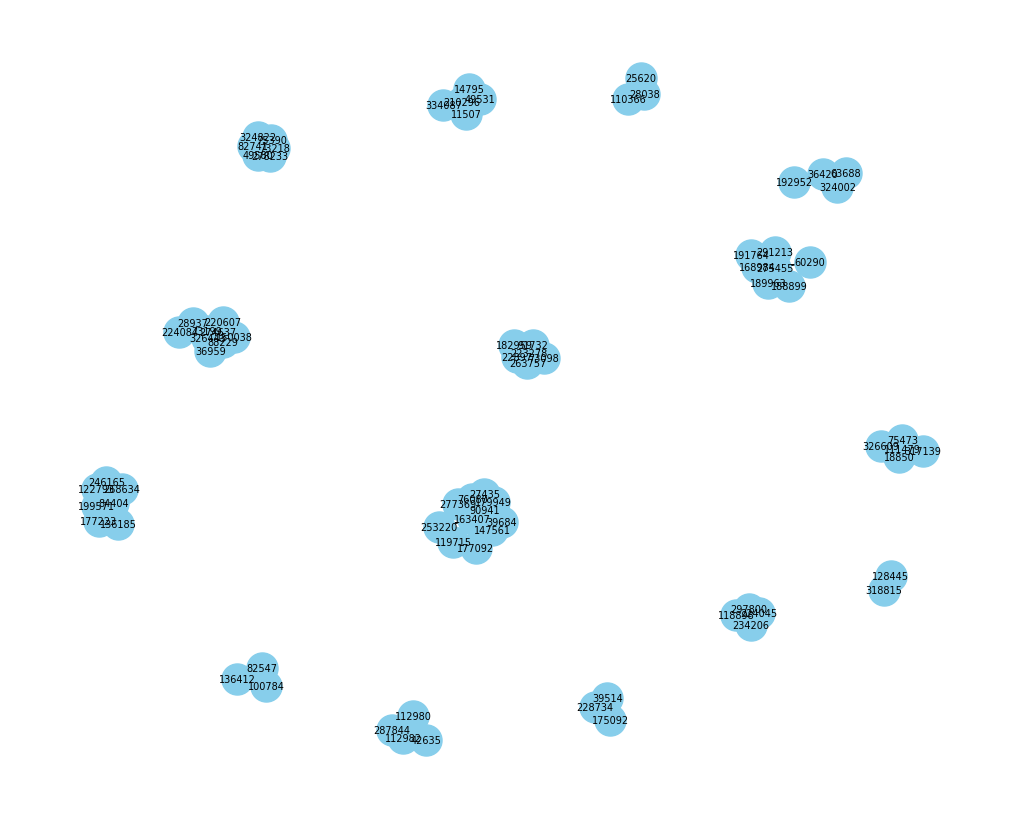

In [5]:
#This code prints the subGraph out of the Graph G

import networkx as nx
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Getting a list of nodes
nodes = list(G.nodes)

# Randomly selecting nodes
selected_nodes = random.sample(nodes, min(15, len(nodes)))

# Creating a subgraph with the selected nodes and their neighbors
neighbors = []
for node in selected_nodes:
    neighbors.extend(list(G.neighbors(node)))

selected_nodes.extend(neighbors)
selected_nodes = list(set(selected_nodes))  # Removing duplicates

# Creating a subgraph with the selected nodes
G_sub = G.subgraph(selected_nodes).copy()  #.copy() to ensure the subgraph is independent

#Subgraph
pos = nx.spring_layout(G_sub)
plt.figure(figsize=(10, 8))
nx.draw(G_sub, pos, node_color='skyblue',edge_color='black', node_size=500, font_size=7,with_labels=True)
nx.draw_networkx_edges(G_sub, pos, edge_color='black')
plt.show()



In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def calculate_normalized_conductance(G_sub, v1, v2):
    total_volume = sum(dict(G_sub.degree()).values())
    
    S = {v1, v2}
    
    vol_S = sum(dict(G_sub.degree(S)).values())
    vol_V_minus_S = total_volume - vol_S
    
    cut_size = nx.cut_size(G_sub, S)
    
    if vol_S > 0 and vol_V_minus_S > 0:
        normalized_conductance = cut_size / min(vol_S, vol_V_minus_S)
    else:
        normalized_conductance = float('inf')
    
    return normalized_conductance, S

def visualize_local_neighborhood(G_sub, v1, v2):
    # Get neighbors of v1 and v2
    neighbors = set(G_sub.neighbors(v1)) | set(G_sub.neighbors(v2))
    
    # Add v1 and v2 to the set of nodes to visualize
    nodes_to_viz = neighbors | {v1, v2}
    
    # Create a subgraph with these nodes
    subgraph = G_sub.subgraph(nodes_to_viz)
    
    pos = nx.spring_layout(subgraph)
    plt.figure(figsize=(10, 8))
    
    # Draw the subgraph
    nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
    nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=500)
    
    # Highlight v1 and v2
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[v1, v2], node_color='yellow', node_size=700)
    
    # Add labels
    nx.draw_networkx_labels(subgraph, pos)
    
    plt.title(f"Local Neighborhood of Vertices {v1} and {v2}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming G is your existing graph
# G = ... (your existing graph)

# Getting a list of nodes
nodes = list(G.nodes)

# Randomly selecting nodes
selected_nodes = random.sample(nodes, min(15, len(nodes)))

# Creating a subgraph with the selected nodes and their neighbors
neighbors = []
for node in selected_nodes:
    neighbors.extend(list(G.neighbors(node)))

selected_nodes.extend(neighbors)
selected_nodes = list(set(selected_nodes))  # Removing duplicates

# Creating a subgraph with the selected nodes
G_sub = G.subgraph(selected_nodes).copy()  # .copy() to ensure the subgraph is independent

# Visualize the subgraph
pos = nx.spring_layout(G_sub)
plt.figure(figsize=(10, 8))
nx.draw(G_sub, pos, node_color='skyblue', edge_color='black', node_size=500, font_size=7, with_labels=True)
nx.draw_networkx_edges(G_sub, pos, edge_color='black')
plt.show()

# Select a random edge and get its endpoints
edge = random.choice(list(G_sub.edges()))
v1, v2 = edge

# Calculate normalized conductance
normalized_conductance, S = calculate_normalized_conductance(G_sub, v1, v2)

print(f"The normalized conductance of the graph for vertices {v1} and {v2} is: {normalized_conductance}")

# Visualize the local neighborhood
visualize_local_neighborhood(G_sub, v1, v2)

# Calculate average normalized conductance for all pairs of vertices with edges
total_conductance = 0
num_pairs = G_sub.number_of_edges()

for edge in G_sub.edges():
    v1, v2 = edge
    conductance, _ = calculate_normalized_conductance(G_sub, v1, v2)
    if isinstance(conductance, float):
        total_conductance += conductance

average_conductance = total_conductance / num_pairs
print(f"The average normalized conductance over all {num_pairs} pairs of connected vertices is: {average_conductance}")


In [43]:

# Function to calculate degree centrality and print it if it exceeds a threshold
def calculate_random_degree_centrality_with_threshold(G_sub, threshold=0.9):
    # Selecting a random node from the graph
    random_node = random.choice(list(G_sub.nodes))
    
    # Calculating the degree centrality of the selected node
    degree_centrality_value = nx.degree_centrality(G_sub).get(random_node, 0)
    
    # Rounding the degree centrality value to 4 decimal places
    degree_centrality_value = round(degree_centrality_value, 4)
    
    # Checking if the degree centrality exceeds the threshold
    if degree_centrality_value > threshold:
        # Print the degree centrality value if it meets the threshold
        print(f"Degree Centrality of {random_node}: {degree_centrality_value:.4f} exceeds the threshold.")
    else:
        print(f"Degree Centrality of {random_node}: {degree_centrality_value:.4f} does not exceed the threshold.")

calculate_random_degree_centrality_with_threshold(G_sub, threshold=0.9)

Degree Centrality of 267725: 0.0084 does not exceed the threshold.


In [92]:
def calculate_random_degree_centrality_with_threshold(G_sub, threshold=0.9):
    # Selecting a random node from the graph
    random_node = random.choice(list(G_sub.nodes))
    
    # Calculating the degree centrality of the selected node
    degree_centrality_value = nx.degree_centrality(G_sub).get(random_node, 0)
    
    # Rounding the degree centrality value to 4 decimal places
    degree_centrality_value = round(degree_centrality_value, 4)
    
    # Checking if the degree centrality exceeds the threshold
    if degree_centrality_value > threshold:
        # Print the degree centrality value if it meets the threshold
        print(f"Degree Centrality of {random_node}: {degree_centrality_value:.4f} exceeds the threshold.")
    else:
        print(f"Degree Centrality of {random_node}: {degree_centrality_value:.4f} does not exceed the threshold.")


In [93]:
# Function to calculate betweenness centrality and print it if it exceeds a threshold
def calculate_random_betweenness_centrality_with_threshold(G_sub, threshold=0.9):
    # Selecting a random node from the graph
    random_node = random.choice(list(G_sub.nodes))
    
    # Calculating the betweenness centrality of the selected node
    betweenness_centrality_value = nx.betweenness_centrality(G_sub).get(random_node, 0)
    
    # Rounding the betweenness centrality value to 4 decimal places
    betweenness_centrality_value = round(betweenness_centrality_value, 4)
    
    # Checking if the betweenness centrality exceeds the threshold
    if betweenness_centrality_value > threshold:
        # Print the betweenness centrality value if it meets the threshold
        print(f"Betweenness Centrality of {random_node}: {betweenness_centrality_value:.4f} exceeds the threshold.")
    else:
        print(f"Betweenness Centrality of {random_node}: {betweenness_centrality_value:.4f} does not exceed the threshold.")

# Function to calculate closeness centrality and print it if it exceeds a threshold

In [94]:
def calculate_random_closeness_centrality_with_threshold(G, threshold=0.9):
    # Selecting a random node from the graph
    random_node = random.choice(list(G_sub.nodes))
    
    # Calculating the closeness centrality of the selected node
    closeness_centrality_value = nx.closeness_centrality(G_sub).get(random_node, 0)
    
    # Rounding the closeness centrality value to 4 decimal places
    closeness_centrality_value = round(closeness_centrality_value, 4)
    
    # Checking if the closeness centrality exceeds the threshold
    if closeness_centrality_value > threshold:
        # Print the closeness centrality value if it meets the threshold
        print(f"Closeness Centrality of {random_node}: {closeness_centrality_value:.4f} exceeds the threshold.")
    else:
        print(f"Closeness Centrality of {random_node}: {closeness_centrality_value:.4f} does not exceed the threshold.")

In [95]:
# Function to calculate eigenvector centrality and print it if it exceeds a threshold
def calculate_random_eigenvector_centrality_with_threshold(G_sub, threshold=0.9):
    # Selecting a random node from the graph
    random_node = random.choice(list(G_sub.nodes))
    
    try:
        # Calculating the eigenvector centrality of the selected node
        eigenvector_centrality_value = nx.eigenvector_centrality(G_sub).get(random_node, 0)
        
        # Rounding the eigenvector centrality value to 4 decimal places
        eigenvector_centrality_value = round(eigenvector_centrality_value, 4)
        
        # Checking if the eigenvector centrality exceeds the threshold
        if eigenvector_centrality_value > threshold:
            # Print the eigenvector centrality value if it meets the threshold
            print(f"Eigenvector Centrality of {random_node}: {eigenvector_centrality_value:.4f} exceeds the threshold.")
        else:
            print(f"Eigenvector Centrality of {random_node}: {eigenvector_centrality_value:.4f} does not exceed the threshold.")
    except nx.PowerIterationFailedConvergence:
        print(f"Failed to calculate eigenvector centrality for node {random_node} due to convergence issues.")
        

In [96]:
calculate_random_degree_centrality_with_threshold(G_sub, threshold=0.1)

# Calculate and print the betweenness centrality of a random node in the subgraph
calculate_random_betweenness_centrality_with_threshold(G_sub, threshold=0.1)

# Calculate and print the closeness centrality of a random node in the subgraph
calculate_random_closeness_centrality_with_threshold(G_sub, threshold=0.1)

# Calculate and print the eigenvector centrality of a random node in the subgraph
calculate_random_eigenvector_centrality_with_threshold(G_sub, threshold=0.1)

903111794


Degree Centrality of 331977: 0.0317 does not exceed the threshold.
Betweenness Centrality of 29823: 0.0000 does not exceed the threshold.
Closeness Centrality of 208236: 0.0794 does not exceed the threshold.
Eigenvector Centrality of 76430: 0.3208 exceeds the threshold.


903111794

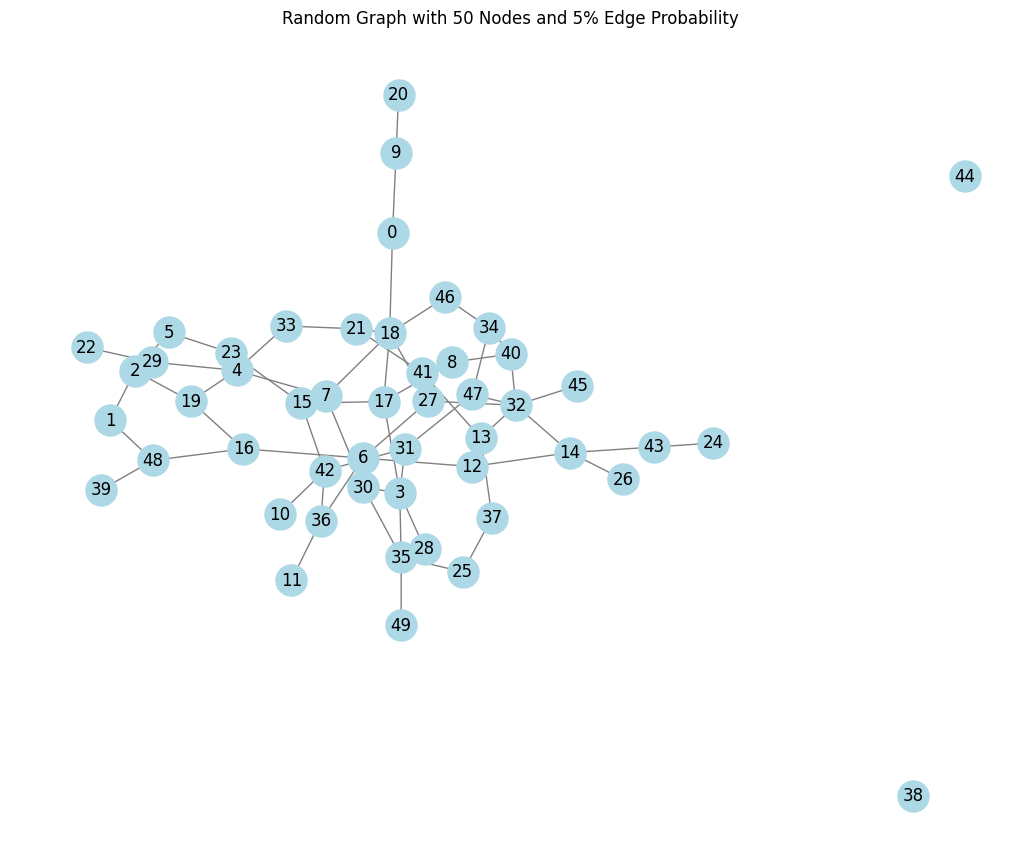

Detected communities around node 43:
Community 0: set()
Community 1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49}
Community 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49}
Community 3: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49}
Community 4: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49}
Community 5: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 

In [20]:
# 1st Algorithm for a random graph
import networkx as nx
from collections import defaultdict, deque
import random

def generate_random_graph(num_nodes=50, edge_probability=0.05):
    """
    Generate a random graph with the specified number of nodes and edge probability.
    """
    D = nx.gnp_random_graph(num_nodes, edge_probability)
    return D

def explore_paths(D, s, max_depth=3):
    paths = []
    queue = deque([(s, [s])])
    while queue:
        node, path = queue.popleft()
        if len(path) > max_depth + 1:
            continue
        paths.append(path)
        for neighbor in D.neighbors(node):
            if neighbor not in path:  # Avoid cycles
                new_path = path + [neighbor]
                queue.append((neighbor, new_path))
    return paths

def choose_centroids(D, paths, max_centroids=10):
    path_counts = defaultdict(int)
    for path in paths:
        path_counts[tuple(path)] += 1
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)
    return [list(path) for path, _ in sorted_paths[:max_centroids]]

def combine_paths(centroid_paths):
    centroid_seeds = defaultdict(list)
    for path in centroid_paths:
        centroid = path[-1]
        centroid_seeds[centroid].extend(path[:-1])
    return centroid_seeds

def detect_community(D, seed_nodes, s, centroid):
    community = set(seed_nodes)
    frontier = set(seed_nodes)
    while frontier:
        node = frontier.pop()
        neighbors = set(D.neighbors(node))
        new_members = neighbors - community
        community.update(new_members)
        frontier.update(new_members)
    return community

def centroid_local_communities(D, s):
    all_paths = explore_paths(D, s)
    centroid_paths = choose_centroids(D, all_paths)
    centroid_seeds = combine_paths(centroid_paths)
    communities = []
    for centroid, seeds in centroid_seeds.items():
        community = detect_community(D, seeds, s, centroid)
        communities.append(community)
    return communities

# Generate a random graph with 50 nodes and 5% edge probability
D = generate_random_graph(num_nodes=50, edge_probability=0.05) #edge probability given because it is random graph

pos = nx.spring_layout(D)
plt.figure(figsize=(10, 8))
nx.draw(D, pos, node_color='lightblue', edge_color='gray', with_labels=True,node_size=500)
plt.title("Random Graph with 50 Nodes and 5% Edge Probability")
plt.axis('off')
plt.show()

# Select a random query node
query_node = random.choice(list(D.nodes()))

# Detect local communities around the query node
communities = centroid_local_communities(D, query_node)
print(f"Detected communities around node {query_node}:")
for i, community in enumerate(communities):
    print(f"Community {i}: {community}")

In [7]:
import networkx as nx
from collections import defaultdict, deque
import random
import plotly.graph_objects as go

# Function to explore paths from a starting node `s` up to a specified depth
def explore_paths(G_sub, s, max_depth=3):
    paths = []
    queue = deque([(s, [s])])  # Initialize the queue with the starting node and its path
    while queue:
        node, path = queue.popleft()  # Pop the first element from the queue
        if len(path) > max_depth + 1:
            continue  # Skip if the path length exceeds the maximum depth
        paths.append(path)  # Add the current path to the list of paths
        for neighbor in G_sub.neighbors(node):  # Explore neighbors of the current node
            if neighbor not in path:  # Avoid cycles by ensuring the neighbor is not already in the path
                new_path = path + [neighbor]
                queue.append((neighbor, new_path))  # Append the new path to the queue
    return paths

# Function to choose centroid paths based on their frequency
def choose_centroids(G_sub, paths, max_centroids=10):
    path_counts = defaultdict(int)
    for path in paths:
        path_counts[tuple(path)] += 1  # Count occurrences of each path
    sorted_paths = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)  # Sort paths by frequency
    return [list(path) for path, _ in sorted_paths[:max_centroids]]  # Select the top `max_centroids` paths

# Function to combine paths into seed nodes for community detection
def combine_paths(centroid_paths):
    centroid_seeds = defaultdict(list)
    for path in centroid_paths:
        centroid = path[-1]  # The last node in the path is considered the centroid
        centroid_seeds[centroid].extend(path[:-1])  # Add the rest of the path as seed nodes
    return centroid_seeds

# Function to detect community starting from seed nodes
def detect_community(G_sub, seed_nodes, s, centroid):
    community = set(seed_nodes)
    frontier = set(seed_nodes)
    while frontier:
        node = frontier.pop()  # Get a node from the frontier set
        neighbors = set(G_sub.neighbors(node))  # Get the neighbors of the node
        new_members = neighbors - community  # Find new members not yet in the community
        community.update(new_members)  # Add new members to the community
        frontier.update(new_members)  # Add new members to the frontier for further exploration
    return community

# Main function to detect local communities around a starting node `s`
def centroid_local_communities(G_sub, s):
    all_paths = explore_paths(G_sub, s)  # Explore all paths from the starting node
    centroid_paths = choose_centroids(G_sub, all_paths)  # Choose centroid paths
    centroid_seeds = combine_paths(centroid_paths)  # Combine paths into seed nodes
    communities = []
    seen_communities = set()
    for centroid, seeds in centroid_seeds.items():
        community = detect_community(G_sub, seeds, s, centroid)  # Detect community for each centroid
        community_frozenset = frozenset(community)
        if community_frozenset not in seen_communities:  # Check for duplicates
            seen_communities.add(community_frozenset)
            communities.append(community)
    return communities

def visualize_communities_2d(G_sub, communities, query_node):
    # Create a layout for the graph
    pos = nx.spring_layout(G_sub)
    
    # Create edge trace
    edge_x = []
    edge_y = []
    for edge in G_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Create node trace
    node_x = []
    node_y = []
    node_text = []
    node_color = []
    
    for node in G_sub.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))
        
        # Assign colors based on community membership
        color = 'lightblue'  # Default color
        for i, community in enumerate(communities):
            if node in community:
                color = f'rgb({(i * 50) % 256}, {(i * 100) % 256}, {(i * 150) % 256})'
                break
        if node == query_node:
            color = 'red'  # Highlight query node
        node_color.append(color)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        hoverinfo='text',
        textposition='top center',
        marker=dict(
            size=10,
            color=node_color,
            line_width=2))

    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace])
    
    # Update layout for better visibility
    fig.update_layout(
        title=f'Graph Communities (Query Node: {query_node})',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[ dict(
            text="",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002 ) ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    
    # Add zoom buttons
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=[{"xaxis.range": [min(node_x)-0.1, max(node_x)+0.1], 
                               "yaxis.range": [min(node_y)-0.1, max(node_y)+0.1]}],
                        label="Reset View",
                        method="relayout"
                    ),
                    dict(
                        args=[{"xaxis.range": [min(node_x)/2.5, max(node_x)/1.5], 
                               "yaxis.range": [min(node_y)/2.5, max(node_y)/1.5]}],
                        label="Zoom In",
                        method="relayout"
                    ),
                    dict(
                        args=[{"xaxis.range": [min(node_x)*1.5, max(node_x)*1.5], 
                               "yaxis.range": [min(node_y)*1.5, max(node_y)*1.5]}],
                        label="Zoom Out",
                        method="relayout"
                    )
                ]),
                pad={"r": 10, "t": 10},
                showactive=False,
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            ),
        ]
    )
    
    return fig

# Main execution
def main(G_sub):
    # Select a random query node
    query_node = random.choice(list(G_sub.nodes()))

    # Detect local communities around the query node
    communities = centroid_local_communities(G_sub, query_node)

    print(f"Detected communities around node {query_node}:")
    for i, community in enumerate(communities):
        print(f"Community {i}: {community}")

    # Visualize the communities
    fig = visualize_communities_2d(G_sub, communities, query_node)
    fig.show()

# If you're running this as a script, you might want to add:
if __name__ == "__main__":
    main(G_sub)


Detected communities around node 75390:
Community 0: set()
Community 1: {'73218', '49580', '75390', '82741', '278233', '324822'}


Query Node: 2


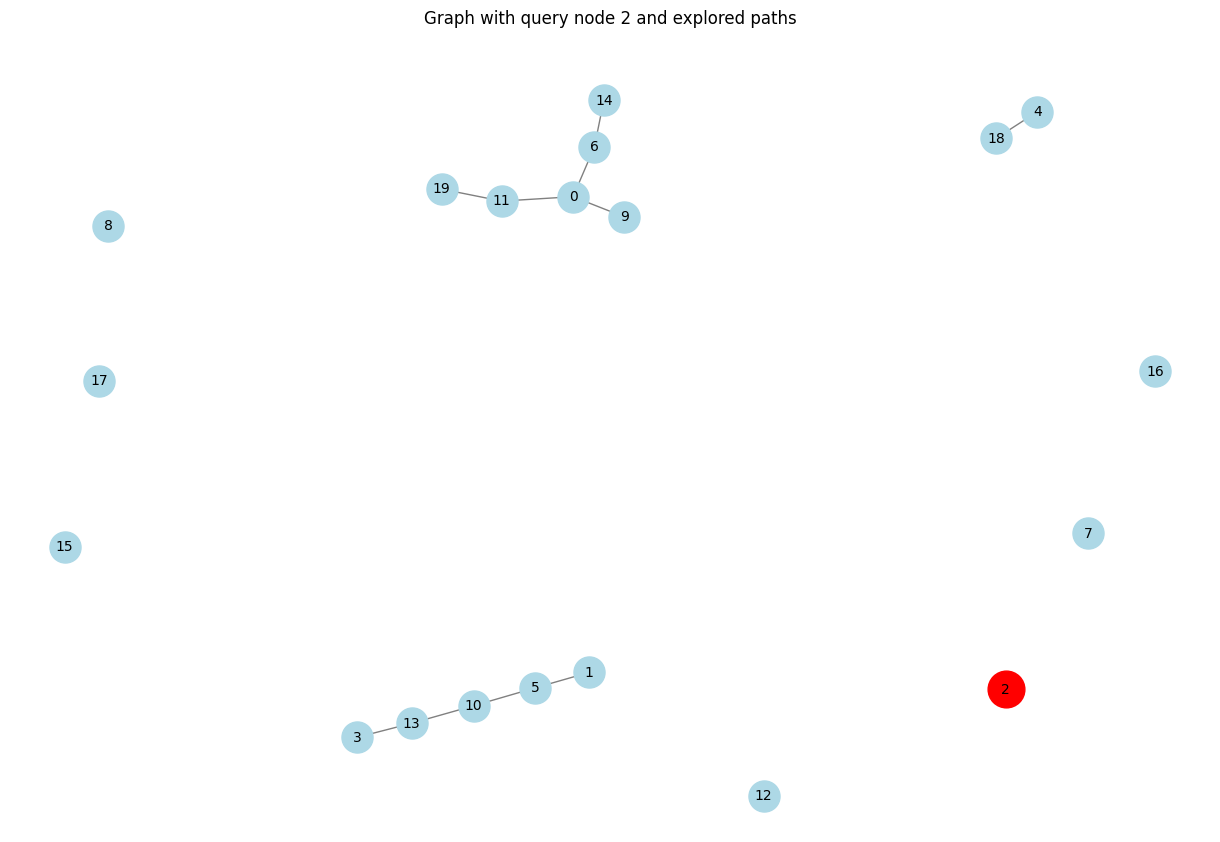

In [8]:
#2ND ALGORITHM FOR RANDOM GRAPH
import networkx as nx
import random
import matplotlib.pyplot as plt

def choose_sim_node(G, last_node, explored_path):
    max_score = -1
    sim_node = None
    for neighbor in G.neighbors(last_node):
        if neighbor not in explored_path:
            # Define your similarity metric here. For simplicity, we'll use the degree as the metric.
            score = G.degree(neighbor)
            if score > max_score:
                max_score = score
                sim_node = neighbor
    return sim_node

def explore_paths(G, s):
    all_paths = []
    for u in G.neighbors(s):
        exploring_path = [s, u]
        last_node = u
        while True:
            sim_node = choose_sim_node(G, last_node, exploring_path)
            if sim_node is not None and sim_node not in exploring_path:
                exploring_path.append(sim_node)
                last_node = sim_node
            else:
                all_paths.append(exploring_path)
                break
    return all_paths

# Create a random graph
def create_random_graph(num_nodes, edge_prob):
    G = nx.erdos_renyi_graph(num_nodes, edge_prob)
    return G

# Function to visualize the graph
def visualize_graph(G, query_node, paths):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    
    # Highlight the query node
    nx.draw_networkx_nodes(G, pos, nodelist=[query_node], node_color='red', node_size=700)
    
    # Highlight the paths
    for path in paths:
        edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges_in_path, edge_color='green', width=2)
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='yellow', node_size=600)
    
    plt.title(f"Graph with query node {query_node} and explored paths")
    plt.show()

# Main function to test the algorithm
if __name__ == "__main__":
    num_nodes = 20
    edge_prob = 0.05

    G = create_random_graph(num_nodes, edge_prob)
    query_node = random.choice(list(G.nodes()))

    print(f"Query Node: {query_node}")
    paths = explore_paths(G, query_node)
    for i, path in enumerate(paths):
        print(f"Path {i + 1}: {path}")

    visualize_graph(G, query_node, paths)


In [9]:
#2ND ALFORITHM FOR AMAZON NETWORK
import networkx as nx
import plotly.graph_objects as go
import random

def choose_sim_node(G_sub, last_node, explored_path):
    max_score = -1
    sim_node = None
    for neighbor in G_sub.neighbors(last_node):
        if neighbor not in explored_path:
            # Define your similarity metric here. For simplicity, we'll use the degree as the metric.
            score = G_sub.degree(neighbor)
            if score > max_score:
                max_score = score
                sim_node = neighbor
    return sim_node

def explore_paths(G_sub, s):
    all_paths = []
    for u in G_sub.neighbors(s):
        exploring_path = [s, u]
        last_node = u
        while True:
            sim_node = choose_sim_node(G_sub, last_node, exploring_path)
            if sim_node is not None and sim_node not in exploring_path:
                exploring_path.append(sim_node)
                last_node = sim_node
            else:
                all_paths.append(exploring_path)
                break
    return all_paths

def visualize_graph_plotly(G_sub, query_node, paths):
    pos = nx.spring_layout(G_sub)
    
    edge_x = []
    edge_y = []
    for edge in G_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G_sub.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[str(node) for node in G_sub.nodes()],
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []
    for node, adjacencies in G_sub.adjacency():
        node_adjacencies.append(len(adjacencies))
        node_text.append(f'Node: {node}<br># of connections: {len(adjacencies)}')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    # Highlight paths
    path_traces = []
    for path in paths:
        path_x = []
        path_y = []
        for node in path:
            x, y = pos[node]
            path_x.append(x)
            path_y.append(y)
        path_trace = go.Scatter(
            x=path_x, y=path_y,
            line=dict(width=4, color='#00FF00'),
            hoverinfo='none',
            mode='lines')
        path_traces.append(path_trace)

    # Highlight query node
    query_trace = go.Scatter(
        x=[pos[query_node][0]], y=[pos[query_node][1]],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            color='red',
            size=15,
            line_width=2),
        text=[f'Query Node: {query_node}'])

    fig = go.Figure(data=[edge_trace, node_trace, query_trace] + path_traces)
    fig.update_layout(
        title=f'Graph with query node {query_node} and explored paths',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[dict(
            text="",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002 )],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    
    fig.show()

def main(G_sub, query_node):
    print(f"Query Node: {query_node}")
    paths = explore_paths(G_sub, query_node)
    for i, path in enumerate(paths):
        print(f"Path {i + 1}: {path}")
    visualize_graph_plotly(G_sub, query_node, paths)

# Choose a random query node
query_node = random.choice(list(G_sub.nodes()))

main(G_sub, query_node)


Query Node: 88229
Path 1: ['88229', '73199', '326443', '274637', '28937', '224084']
Path 2: ['88229', '326443', '73199', '274637', '28937', '224084']
Path 3: ['88229', '36959', '73199', '326443', '274637', '28937', '224084']
Path 4: ['88229', '220607', '73199', '326443', '274637', '28937', '224084']
Path 5: ['88229', '274637', '73199', '326443', '28937', '224084']
Path 6: ['88229', '150038', '73199', '326443', '274637', '28937', '224084']


In [6]:
import networkx as nx
import plotly.graph_objects as go

def create_interactive_graph(G_sub):
    # Create edge trace
    edge_x = []
    edge_y = []
    for edge in G_sub.edges():
        x0, y0 = G_sub.nodes[edge[0]]['pos']
        x1, y1 = G_sub.nodes[edge[1]]['pos']
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    # Create node trace
    node_x = []
    node_y = []
    for node in G_sub.nodes():
        x, y = G_sub.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2
        )
    )

    # Color node points by the number of connections
    node_adjacencies = []
    node_text = []
    for node, adjacencies in G_sub.adjacency():
        node_adjacencies.append(len(adjacencies))
        node_text.append(f'Node {node}<br># of connections: {len(adjacencies)}')
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Network Graph',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    return fig

# Usage example:
# Assuming you have already created your NetworkX graph G_sub

pos = nx.spring_layout(G_sub)
nx.set_node_attributes(G_sub, pos, 'pos')
fig = create_interactive_graph(G_sub)
fig.show()


In [10]:
#3RD ALGORITHM FOR AMAZON NETWORK
import networkx as nx
import math
import plotly.graph_objects as go
import random

def sim(G_sub, u, last_node):
    N_u = set(G_sub.neighbors(u))
    N_v = set(G_sub.neighbors(last_node))
    
    numerator = len(N_u.intersection(N_v))
    denominator = math.sqrt(len(N_u) * len(N_v))
    
    if denominator == 0:
        return 0
    return numerator / denominator

def choose_sim_node(G_sub, last_node):
    max_score = -1
    sim_node = None
    for u in G_sub.neighbors(last_node):
        score = sim(G_sub, u, last_node)
        if score > max_score:
            max_score = score
            sim_node = u
    
    if sim_node is not None:
        print(f"Chosen sim_node: {sim_node}, Similarity score: {max_score:.4f}")
    else:
        print("No similar node found.")
    
    return sim_node

def visualize_graph(G_sub, last_node, sim_node):
    pos = nx.spring_layout(G_sub)
    
    edge_x = []
    edge_y = []
    for edge in G_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G_sub.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[str(node) for node in G_sub.nodes()],
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            reversescale=True,
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    node_adjacencies = []
    node_text = []
    for node in G_sub.nodes():
        adjacencies = list(G_sub.neighbors(node))
        node_adjacencies.append(len(adjacencies))
        node_text.append(f'Node {node}<br># of connections: {len(adjacencies)}')
    
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    highlight_trace = go.Scatter(
        x=[pos[last_node][0], pos[sim_node][0]],
        y=[pos[last_node][1], pos[sim_node][1]],
        mode='markers+text',
        marker=dict(
            color=['red', 'green'],
            size=15,
            symbol=['star', 'star']
        ),
        text=[f'Last Node: {last_node}', f'Similar Node: {sim_node}'],
        textposition="bottom center",
        hoverinfo='text'
    )

    fig = go.Figure(data=[edge_trace, node_trace, highlight_trace],
                    layout=go.Layout(
                        title=f'Graph Similarity Visualization',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002)],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    
    fig.show()

if len(G_sub.nodes()) > 0:
    last_node = random.choice(list(G_sub.nodes()))
    print(f"Using node {last_node} as the last_node")
    sim_node = choose_sim_node(G_sub, last_node)
    if sim_node:
        visualize_graph(G_sub, last_node, sim_node)
    else:
        print("Error: No similar node found. Unable to visualize.")
else:
    print("Error: The graph is empty. Please ensure your G_sub graph has nodes before running this code.")


Using node 63688 as the last_node
Chosen sim_node: 324002, Similarity score: 0.5000


In [11]:
#4TH ALGORITHM FOR AMAZON NETWORK
import networkx as nx
import random
import plotly.graph_objects as go

def choose_centroids(G, all_paths):
    cens_paths = {}
    
    for path in all_paths:
        if len(path) < 2:
            continue
        
        node1 = path[-2]
        node2 = path[-1]
        
        if G.degree(node1) > G.degree(node2):
            centroid_node = node1
        elif G.degree(node1) < G.degree(node2):
            centroid_node = node2
        else:
            centroid_node = max(node1, node2)
        
        if centroid_node not in cens_paths:
            cens_paths[centroid_node] = []
        
        cens_paths[centroid_node].append(path)
    
    return cens_paths

# Generate a random graph
G = nx.erdos_renyi_graph(50, 0.5, seed=42)

# Generate some random paths for demonstration
all_paths = [list(nx.shortest_path(G, source=random.choice(list(G.nodes())),
                                   target=random.choice(list(G.nodes()))))
             for _ in range(5)]

# Call the choose_centroids function
cens_paths = choose_centroids(G, all_paths)

# Plotting using Plotly
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes

# Draw the graph
edge_trace = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace.append(go.Scatter(x=[x0, x1], y=[y0, y1],
                                 line=dict(width=1, color='#888'),
                                 hoverinfo='none',
                                 mode='lines'))

node_trace = go.Scatter(x=[], y=[], text=[], mode='markers+text',
                        hoverinfo='text', textposition="top center",
                        marker=dict(color=[], size=[], line=None))

for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += (x,)
    node_trace['y'] += (y,)
    connections = G.degree(node)
    node_trace['text'] += (f'{node}: {connections}',)
    node_trace['marker']['color'] += ('#1f78b4',)
    node_trace['marker']['size'] += (10 + connections,)  # Adjust size based on connections

# Highlight centroid nodes and their paths
centroid_trace = go.Scatter(x=[], y=[], text=[], mode='markers+text',
                            hoverinfo='text', textposition="top center",
                            marker=dict(color='red', size=[], line=dict(width=2, color='DarkSlateGrey')))

for centroid, paths in cens_paths.items():
    x, y = pos[centroid]
    centroid_trace['x'] += (x,)
    centroid_trace['y'] += (y,)
    connections = G.degree(centroid)
    centroid_trace['text'] += (f'{centroid}: {connections}',)
    centroid_trace['marker']['size'] += (15 + connections,)  # Adjust size based on connections
    
    for path in paths:
        path_edges = zip(path[:-1], path[1:])
        for edge in path_edges:
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_trace.append(go.Scatter(x=[x0, x1], y=[y0, y1],
                                         line=dict(width=2, color='red'),
                                         hoverinfo='none',
                                         mode='lines'))

fig = go.Figure(data=edge_trace + [node_trace, centroid_trace],
                layout=go.Layout(showlegend=False, hovermode='closest'))

fig.update_layout(title='Graph with Centroid Nodes, Paths, and Connection Numbers',
                  margin=dict(b=20, l=5, r=5, t=40),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

fig.show()

Centroid Node: 76080
  Path: ['73218', '175092', '76080']
Centroid Node: 49531
  Path: ['36420', '228734', '49531']
Centroid Node: 210296
  Path: ['326609', '210296']
Centroid Node: 84404
  Path: ['188899', '275455', '84404', '175092']
Centroid Node: 278233
  Path: ['36959', '278233']


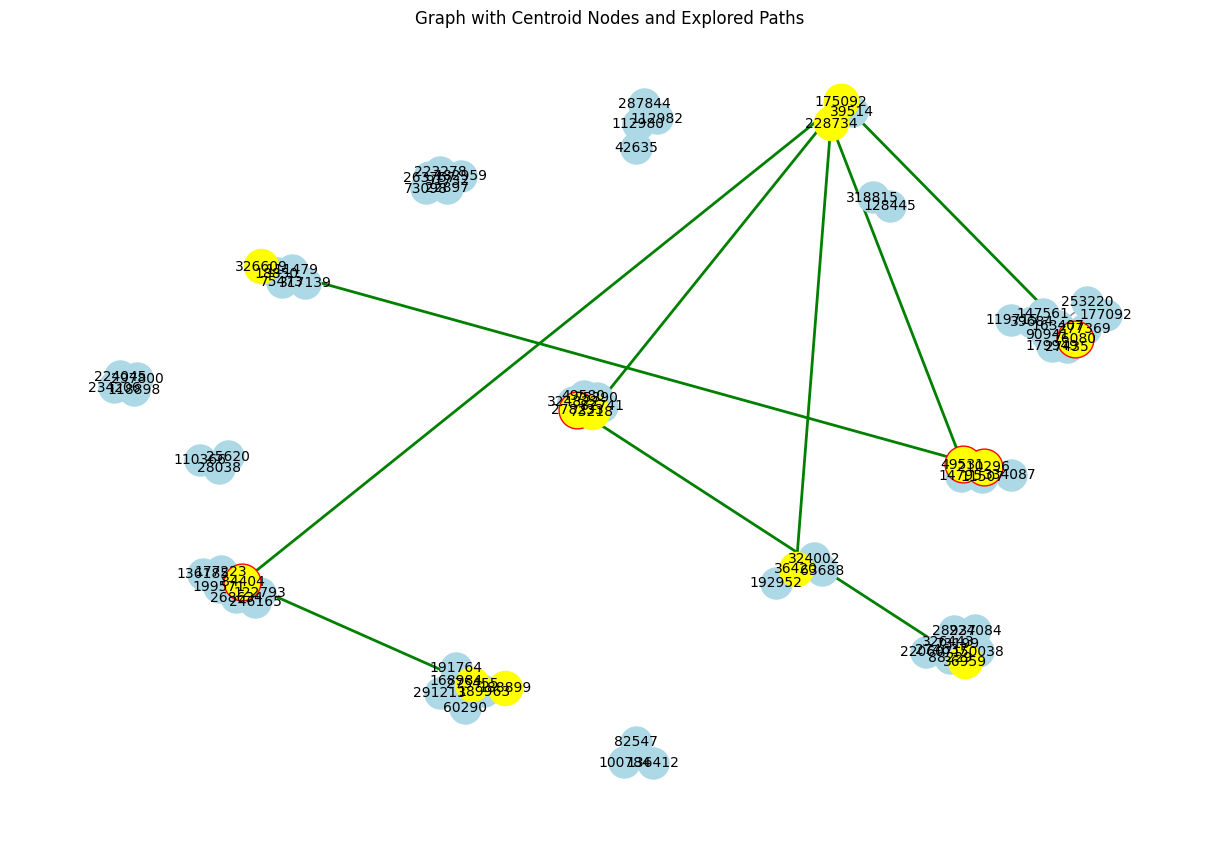

In [12]:
#4TH ALGORITHM FOR AMAZON NETWORK
import networkx as nx
import matplotlib.pyplot as plt
import random

def choose_centroids(G_sub, all_paths):
    cens_paths = {}
    for path in all_paths:
        if len(path) < 2:
            continue
        
        if G_sub.degree(path[-2]) > G_sub.degree(path[-1]):
            centroid_node = path[-2]
        elif G_sub.degree(path[-2]) < G_sub.degree(path[-1]):
            centroid_node = path[-1]
        else:
            centroid_node = max(path[-2], path[-1])
        
        if centroid_node not in cens_paths:
            cens_paths[centroid_node] = []
        cens_paths[centroid_node].append(path)
    
    return cens_paths

def visualize_centroid_paths(G_sub, centroid_paths):
    pos = nx.spring_layout(G_sub)
    plt.figure(figsize=(12, 8))
    # Draw the graph
    nx.draw(G_sub, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    
    # Highlight the centroid nodes
    for centroid in centroid_paths.keys():
        nx.draw_networkx_nodes(G_sub, pos, nodelist=[centroid], node_color='red', node_size=700)
    
    # Highlight the paths
    for paths in centroid_paths.values():
        for path in paths:
            edges_in_path = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
            nx.draw_networkx_edges(G_sub, pos, edgelist=edges_in_path, edge_color='green', width=2)
            nx.draw_networkx_nodes(G_sub, pos, nodelist=path, node_color='yellow', node_size=600)
    
    plt.title("Graph with Centroid Nodes and Explored Paths")
    plt.show()

# If you have a pre-existing graph, you can use it here

# Create sample paths
all_paths = [random.sample(list(G_sub.nodes()), random.randint(2, 5)) for _ in range(5)]

# Run the choose_centroids algorithm
centroid_paths = choose_centroids(G_sub, all_paths)

# Print the results
for centroid, paths in centroid_paths.items():
    print(f"Centroid Node: {centroid}")
    for path in paths:
        print(f"  Path: {path}")

# Visualize the results
visualize_centroid_paths(G_sub, centroid_paths)

In [13]:
import networkx as nx
import plotly.graph_objects as go

def choose_centroids(G_sub, all_paths):
    cens_paths = {}
    for path in all_paths:
        if len(path) < 2:
            continue
        
        last_node = path[-1]
        second_last_node = path[-2]
        
        centroid_node = second_last_node if G_sub.degree(second_last_node) > G_sub.degree(last_node) else last_node
        if G_sub.degree(second_last_node) == G_sub.degree(last_node):
            centroid_node = max(second_last_node, last_node)
        
        if centroid_node not in cens_paths:
            cens_paths[centroid_node] = []
        cens_paths[centroid_node].append(path)
    
    return cens_paths

def explore_paths(G, start_node, max_depth=3):
    paths = [[start_node]]
    for _ in range(max_depth):
        new_paths = []
        for path in paths:
            for neighbor in G.neighbors(path[-1]):
                if neighbor not in path:
                    new_paths.append(path + [neighbor])
        paths.extend(new_paths)
    return paths

def visualize_centroid_paths(G_sub, cens_paths):
    pos = nx.spring_layout(G_sub)
    
    edge_trace = []
    for edge in G_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace.append(go.Scatter(x=[x0, x1], y=[y0, y1],
                                     line=dict(width=1, color='#888'),
                                     hoverinfo='none',
                                     mode='lines'))

    node_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers+text',
        hoverinfo='text', textposition="top center",
        marker=dict(
            color=[], size=[], colorscale='YlOrRd',
            colorbar=dict(thickness=15, title='Node Degree',
                          xanchor='left', titleside='right')
        )
    )

    for node in G_sub.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_degree = G_sub.degree(node)
        node_trace['marker']['color'] += tuple([node_degree])
        node_trace['marker']['size'] += tuple([10 + node_degree * 2])
        node_trace['text'] += tuple([f'Node {node}<br>Degree: {node_degree}'])

    centroid_trace = go.Scatter(
        x=[], y=[], text=[], mode='markers',
        hoverinfo='text',
        marker=dict(color='red', size=20, symbol='star')
    )

    for centroid in cens_paths.keys():
        x, y = pos[centroid]
        centroid_trace['x'] += tuple([x])
        centroid_trace['y'] += tuple([y])
        centroid_trace['text'] += tuple([f'Centroid Node: {centroid}'])

    path_traces = []
    for centroid, paths in cens_paths.items():
        for path in paths:
            x = [pos[node][0] for node in path]
            y = [pos[node][1] for node in path]
            path_traces.append(go.Scatter(x=x, y=y, mode='lines',
                                          line=dict(width=2, color='green'),
                                          hoverinfo='none'))

    layout = go.Layout(
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        title='Graph with Centroid Nodes and Explored Paths'
    )

    fig = go.Figure(data=edge_trace + [node_trace, centroid_trace] + path_traces, layout=layout)
    fig.show()

def combine_paths(cens_paths):
    cens_seeds = {}
    for cen, paths in cens_paths.items():
        combined_set = set()
        for path in paths:
            combined_set.update(path)
        cens_seeds[cen] = combined_set
    return cens_seeds

# Example usage:

# Assuming G_sub is defined elsewhere
query_node = list(G_sub.nodes())[0]  # Or choose any node you prefer as the query node

# Use the previously defined functions to explore paths
all_paths = explore_paths(G_sub, query_node)

# Run the choose_centroids algorithm
cens_paths = choose_centroids(G_sub, all_paths)

# Visualize the results
visualize_centroid_paths(G_sub, cens_paths)

# Print the results
for centroid, paths in cens_paths.items():
    print(f"Centroid Node: {centroid}")
    for path in paths:
        print(f"  Path: {path}")

# Combine paths
result = combine_paths(cens_paths)
print("The result is", result)


Centroid Node: 84404
  Path: ['177223', '84404']
  Path: ['177223', '84404']
  Path: ['177223', '84404', '136185']
  Path: ['177223', '84404', '122793']
  Path: ['177223', '84404', '199571']
  Path: ['177223', '84404', '246165']
  Path: ['177223', '84404', '268634']
  Path: ['177223', '136185', '84404']
  Path: ['177223', '199571', '84404']
  Path: ['177223', '84404']
  Path: ['177223', '84404', '136185']
  Path: ['177223', '84404', '122793']
  Path: ['177223', '84404', '199571']
  Path: ['177223', '84404', '246165']
  Path: ['177223', '84404', '268634']
  Path: ['177223', '136185', '84404']
  Path: ['177223', '199571', '84404']
  Path: ['177223', '84404', '136185']
  Path: ['177223', '84404', '122793']
  Path: ['177223', '84404', '199571']
  Path: ['177223', '84404', '246165']
  Path: ['177223', '84404', '268634']
  Path: ['177223', '136185', '84404']
  Path: ['177223', '199571', '84404']
  Path: ['177223', '136185', '84404', '122793']
  Path: ['177223', '136185', '84404', '199571']
 

In [14]:
import networkx as nx
import numpy as np
import random
import plotly.graph_objects as go

def detect_community(G_sub, cens_seeds, s, centroid):
    def initialize_probability_vector(G_sub, cens_seeds, s, centroid):
        p0 = np.zeros(len(G_sub))
        nodes = list(G_sub.nodes())
        for node in set(cens_seeds + [s, centroid]):  # Using set to avoid duplicates
            if node in nodes:
                p0[nodes.index(node)] = 1
        return p0 / np.sum(p0) if np.sum(p0) > 0 else p0

    def personalized_pagerank(G_sub, p0, alpha=0.85, max_iter=100, tol=1e-6):
        p = p0.copy()
        nodes = list(G_sub.nodes())
        for _ in range(max_iter):
            prev_p = p.copy()
            for i, node in enumerate(nodes):
                neighbors = list(G_sub.neighbors(node))
                if neighbors:
                    p[i] = (1 - alpha) * p0[i] + alpha * sum(prev_p[nodes.index(neigh)] / G_sub.degree(neigh) for neigh in neighbors)
            if np.linalg.norm(p - prev_p, 1) < tol:
                break
        return p

    def conductance(G_sub, S):
        S = set(S)
        vol_S = sum(G_sub.degree(node) for node in S)
        cut_S = sum(1 for u, v in G_sub.edges() if (u in S) != (v in S))
        vol_G = sum(dict(G_sub.degree()).values())
        denominator = min(vol_S, vol_G - vol_S)
        return cut_S / denominator if denominator > 0 else float('inf')

    def sweep_operation(G_sub, p):
        nodes = list(G_sub.nodes())
        sorted_indices = np.argsort(p)[::-1]
        best_conductance = float('inf')
        best_community = []
        current_community = []
        for i in sorted_indices:
            current_community.append(nodes[i])
            cond = conductance(G_sub, current_community)
            if cond < best_conductance:
                best_conductance = cond
                best_community = current_community.copy()
        return best_community

    # Step 1: Initialize probability vector
    p0 = initialize_probability_vector(G_sub, cens_seeds, s, centroid)

    # Step 2: Apply Personalized PageRank
    p = personalized_pagerank(G_sub, p0)

    # Step 3 & 4: Perform sweep operation and return community
    C = sweep_operation(G_sub, p)

    return C

def visualize_graph(G, community, s, cens_seeds, centroid):
    pos = nx.spring_layout(G)
    
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    node_hover_text = []
    node_color = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(str(node))  # Always display node ID
        
        # Prepare hover text
        hover_info = f'Node: {node}, # of connections: {G.degree(node)}'
        if node in community:
            hover_info += ' (In Community)'
        if node == s:
            hover_info += ' (Query Node)'
            node_color.append('red')  # Set query node color to red
        elif node in cens_seeds:
            hover_info += ' (Seed Node)'
            node_color.append('green')  # Set seed nodes color to green
        elif node == centroid:
            hover_info += ' (Centroid Node)'
            node_color.append('purple')  # Set centroid node color to purple
        else:
            node_color.append('blue')  # Set other nodes color to blue
        node_hover_text.append(hover_info)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        text=node_text,  # Display node ID as text
        textposition='top center',
        hovertext=node_hover_text,
        marker=dict(
            color=node_color,
            size=[25 if node in community else 15 for node in G.nodes()],  # Larger size for community nodes
            line=dict(width=[2 if node in community else 1 for node in G.nodes()], color='black')  # Border for community nodes
        ))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='<br>Network graph with Node IDs and Highlighted Query Node',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002 ) ],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    # Add a legend
    for color, label in [('red', 'Query Node'), ('green', 'Seed Node'), ('purple', 'Centroid Node'), ('blue', 'Other Nodes')]:
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            legendgroup=label,
            showlegend=True,
            name=label
        ))

    fig.update_layout(legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))

    fig.show()

# Assuming the graph `G_sub` and the variable `centroid` are defined elsewhere in your code
# Select a random node from G_sub for 's'
s = random.choice(list(G_sub.nodes()))

# Define other parameters
cens_seeds = random.sample(list(G_sub.nodes()), min(2, len(G_sub)))  # Select 2 random nodes as seeds

# Call the function
C = detect_community(G_sub, cens_seeds, s, centroid)

# Print the result
print("Random query node 's':", s)
print("Random seed nodes 'cens_seeds':", cens_seeds)
print("Detected community:", C)

# Visualize the graph
visualize_graph(G_sub, C, s, cens_seeds, centroid)


Random query node 's': 179949
Random seed nodes 'cens_seeds': ['220607', '82547']
Detected community: ['82547', '246165', '100784', '136412', '179949', '220607', '84404', '163407', '268634', '326443', '73199', '90941', '122793', '88229', '274637', '76080', '27435', '199571', '177223', '36959', '28937', '277369', '136185', '150038', '39684', '147561', '224084', '177092', '253220', '119715']
